In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt

def BuildData(folder, sound_engine_name, date):

    # Get the list of files in the 'editor_data' folder
    folder_path = os.path.join(os.getcwd(), folder)
    file_list = os.listdir(folder_path)

    # Filter the files that contain 'CsoundUnity' in their names
    filtered_files = [file for file in file_list if sound_engine_name in file and date in file]

    # Initialize an empty DataFrame to store the merged data
    merged_df = pd.DataFrame()

    # Iterate over the filtered files and merge them into the DataFrame
    for file in filtered_files:
        file_path = os.path.join(folder_path, file)
        df = pd.read_csv(file_path)
        merged_df = pd.concat([merged_df, df])

    # Group the data by 'sources' column and assign contiguous group numbers
    grouped_df = merged_df.groupby(merged_df['sources'].ne(merged_df['sources'].shift()).cumsum())  

    def dataStats(field):
        # Initialize an empty DataFrame to store the results
        result_df = pd.DataFrame()
        # Iterate over the groups and calculate descriptive statistics
        for name, group in grouped_df:
            
            # Calculate descriptive statistics for the 'audio_frame_t_ms' column
            stats = group[field].describe()
            
            # Calculate the median
            median = group[field].median()
            
            # Create a new DataFrame with the source, audio_frame_t_ms, and descriptive statistics
            temp_df = pd.DataFrame({'sources': group['sources'].iloc[0],
                                    'count': stats['count'],
                                    'mean': stats['mean'],
                                    'std': stats['std'],
                                    'min': stats['min'],
                                    '25%': stats['25%'],
                                    '50%': stats['50%'],
                                    '75%': stats['75%'],
                                    'max': stats['max'],
                                    'median': median}, index=[0])
            
            # Append the temporary DataFrame to the result DataFrame
            result_df = pd.concat([result_df, temp_df], ignore_index=True)

        # return the result DataFrame
        return result_df
    
    return dataStats('audio_frame_t_ms'), dataStats('audio_memory_mb')

def Plot(dataPerSources, sound_engine_name, field_to_show, color='blue', ecolor='orange'):

    # Set the x-axis values as the index of the dataframe
    x = dataPerSources.index

    # Set the y-axis values as the mean values from the 'mean' column
    y = dataPerSources['mean']

    # Plot the data
    #plt.plot(x, y, color='blue', marker='o', linestyle='-', label='Mean')

    # Set the x-axis values as the index of the dataframe
    x = dataPerSources.index

    # Set the y-axis values as the mean values from the 'mean' column
    y = dataPerSources['mean']

    # Set the y-axis error values as the standard deviation values from the 'std' column
    y_error = dataPerSources['std']

    # Plot the mean with error bars
    plt.errorbar(x, y, yerr=y_error, fmt='o-', label='Mean', color=color, ecolor=ecolor, elinewidth=1, capsize=3)

    # Set Title
    plt.title(field_to_show + 'per Number of Sources - ' + sound_engine_name)

    # Set the x-axis label
    plt.xlabel('Number of Sources')
    # Set the y-axis label
    plt.ylabel('Audio Frame Time (ms)')

    # Set the x-axis ticks as the values in dataPerSources['sources']
    plt.xticks(x, dataPerSources['sources'])


    # Rest of the code...
    

    # Show the plot
    #plt.show() # Uncomment this line to show individual plots



def Plot_CPU_Memory(folder, sound_engine_name, date, color_frame_time='blue', color_memory='green', ecolor_frame_time='orange', ecolor_memory='cyan'):
    frame_time_data, memory_data = BuildData(folder, sound_engine_name, date)
    Plot(frame_time_data, sound_engine_name, 'Audio Frame Time (ms)', color=color_frame_time, ecolor=ecolor_frame_time)
    Plot(memory_data, sound_engine_name, 'Audio Memory (MB)', color=color_memory, ecolor=ecolor_memory)



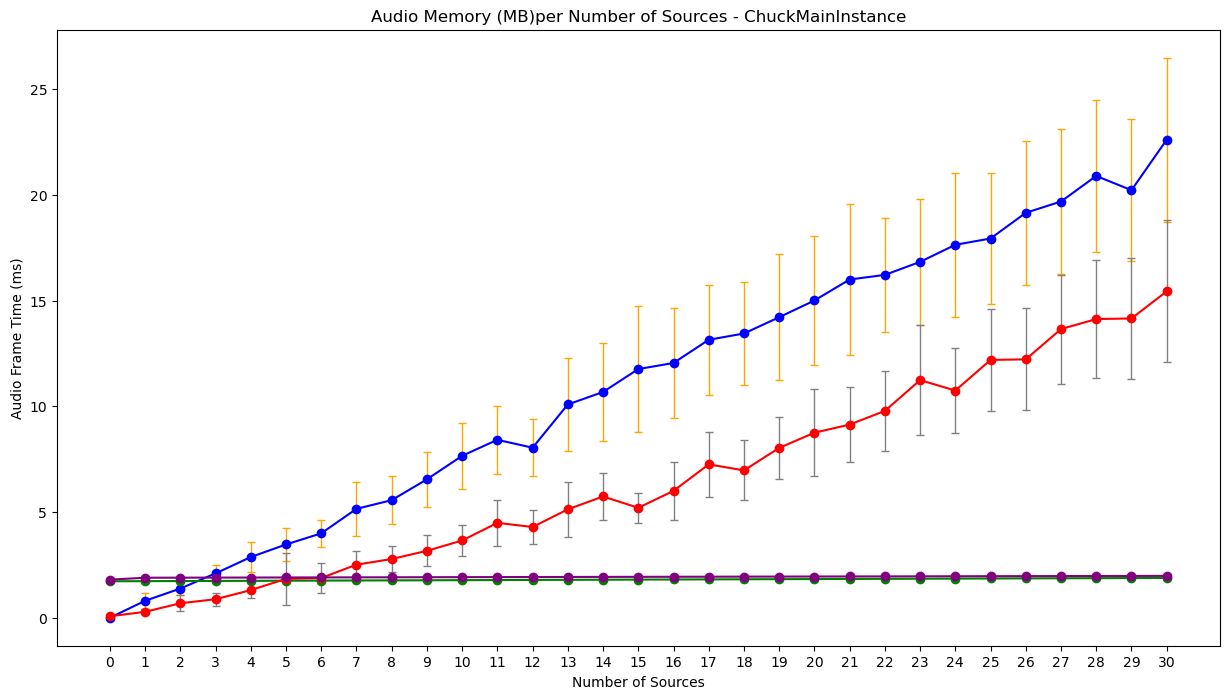

In [2]:
#Plot('CsoundUnity', '2024-02-23_16-13-02')
#Plot('ChuckMainInstance', '2024-02-23_16-19-29')

plt.figure(figsize=(15, 8))

folder = 'editor_data'

sound_engine = 'CsoundUnity'
date = '2024-03-04_11-15-51'
Plot_CPU_Memory(folder, sound_engine, date)

sound_engine = 'ChuckMainInstance'
date = '2024-03-04_11-19-53'
Plot_CPU_Memory(folder, sound_engine, date, color_frame_time='red', color_memory='purple', ecolor_frame_time='grey', ecolor_memory='cyan')

plt.show()

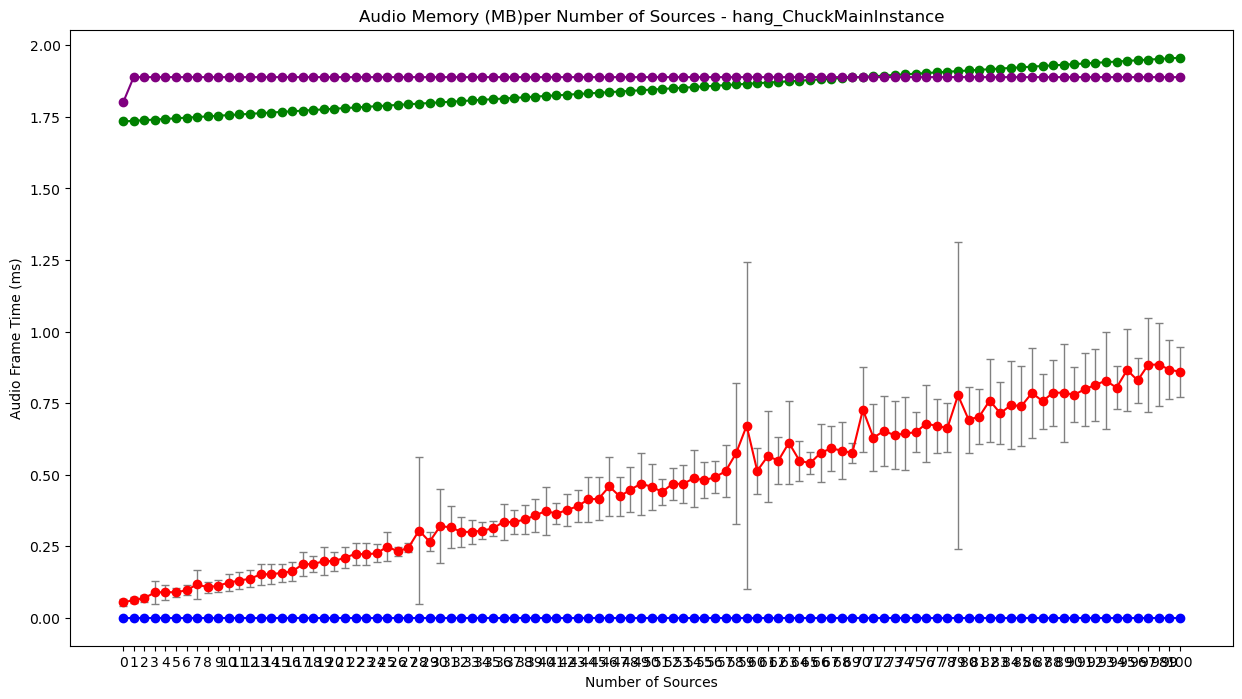

In [4]:
#Plot('CsoundUnity', '2024-02-23_16-13-02')
#Plot('ChuckMainInstance', '2024-02-23_16-19-29')

plt.figure(figsize=(15, 8))

folder = 'editor_data'

sound_engine = 'hang_CsoundUnity'
date = '2024-03-04_16-18-13'
Plot_CPU_Memory(folder, sound_engine, date)

sound_engine = 'hang_ChuckMainInstance'
date = '2024-03-04_16-33-36'
Plot_CPU_Memory(folder, sound_engine, date, color_frame_time='red', color_memory='purple', ecolor_frame_time='grey', ecolor_memory='cyan')

plt.show()

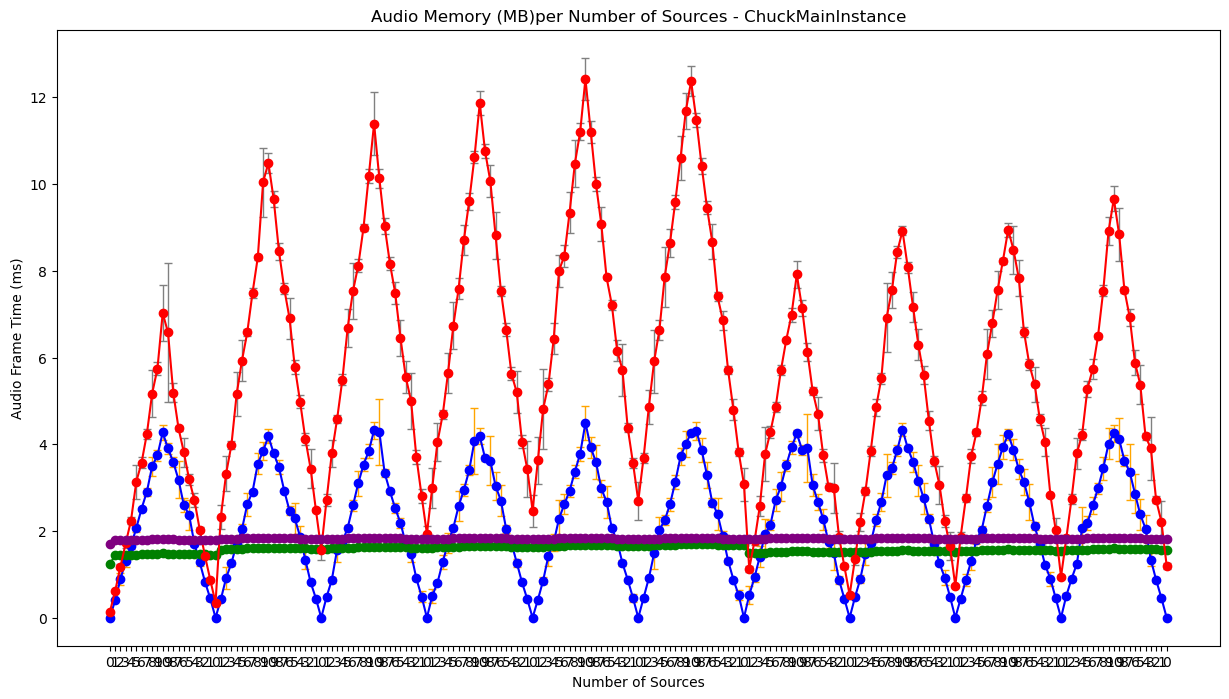

In [4]:

plt.figure(figsize=(15, 8))

folder = 'meta_quest_data/csound'
sound_engine = 'CsoundUnity'
date = '2024-02-29_17-16-31'
Plot_CPU_Memory(folder, sound_engine, date)

folder = 'meta_quest_data/chuck'
sound_engine = 'ChuckMainInstance'
date = '2024-02-29_17-29-00'
Plot_CPU_Memory(folder, sound_engine, date, color_frame_time='red', color_memory='purple', ecolor_frame_time='grey', ecolor_memory='cyan')

plt.show()